<a href="https://colab.research.google.com/github/Awerdos/Anomaly-Detection-with-AutoEncoder/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64

dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=transform)
data = dataset.data

mask_normal = np.where(dataset.targets == 4)[0]
mask_anomaly = np.where(dataset.targets != 4)[0]

Numebrs = []
Normal = torch.utils.data.Subset(dataset, mask_normal)
Anomaly = torch.utils.data.Subset(dataset, mask_anomaly)

# Data for AutoEncoders
len_normal = len(Normal)
len_trainset_ae = int(0.7 * len_normal)
len_testset_ae = len_normal - len_trainset_ae

trainset_ae, testset_ae = torch.utils.data.random_split(Normal, [len_trainset_ae, len_testset_ae])

trainloader_ae = torch.utils.data.DataLoader(trainset_ae, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_ae_4 = torch.utils.data.DataLoader(testset_ae, batch_size=64, shuffle=True, num_workers=2)
testloader_ae = torch.utils.data.DataLoader(Anomaly, batch_size=64, shuffle=True, num_workers=2)

# Data for Classifier
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=transform)

dataset.targets = torch.where(dataset.targets == 4, 1 , 0)
len_dataset = len(dataset)
len_trainset_classifier = int(0.7 * len_dataset)
len_testset_classifier = len_dataset - len_trainset_classifier

trainset_classifier, testset_classfier = torch.utils.data.random_split(dataset, [len_trainset_classifier, len_testset_classifier])

trainloader_class = torch.utils.data.DataLoader(trainset_classifier, batch_size=64, shuffle=True, num_workers=2)
testloader_class = torch.utils.data.DataLoader(testset_classfier, batch_size=1, shuffle=True, num_workers=2)

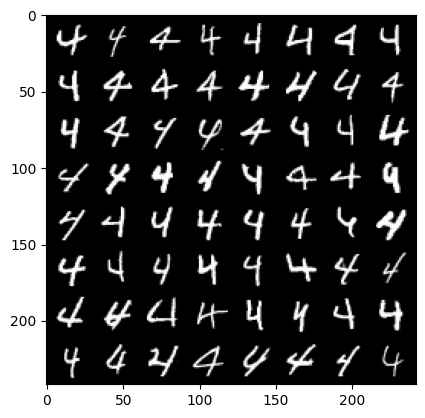

In [ ]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))


dataiter = iter(trainloader_ae)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
plt.show()

In [ ]:
class AutoEncoder_convolutional(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 7)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self,x):
    compressed = self.encoder(x)
    decompressed = self.decoder(compressed)
    return decompressed

In [ ]:
class AutoEncoder_linear(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64)
    )

    self.decoder = nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid(),
        nn.Unflatten(1, (1, 28, 28))
    )

  def forward(self,x):
    compressed = self.encoder(x)
    decompressed = self.decoder(compressed)
    return decompressed

In [ ]:
class Classifier_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 14 * 14, 2)
        )

  def forward(self, x):
        return self.network(x)

In [ ]:
def E(x_pred,x):
  return torch.mean((x - x_pred) ** 2)

In [ ]:
def train_AutoEncoder(model, num_epoch):
  print(f"Model: {model.__class__.__name__}")
  start_time = time.time()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(num_epoch):
    running_loss = 0.0

    for i,data in enumerate(trainloader_ae):
      input, target = data

      optimizer.zero_grad()

      forward = model(input)
      loss = E(forward, input)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f'[{epoch + 1}/{num_epoch}] loss: {running_loss / len(trainloader_ae):.3f}')

  print(f'Finished Training in {time.time() - start_time:.2f}')

In [ ]:
def train_Classifier(model, num_epoch):
  print(f"Model: {model.__class__.__name__}")
  start_time = time.time()

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(num_epoch):
    running_loss = 0.0

    for i,data in enumerate(trainloader_class):
      input, target = data

      optimizer.zero_grad()

      forward = model(input)
      loss = criterion(forward, target)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f'[{epoch + 1}/{num_epoch}] loss: {running_loss / len(trainloader_class):.3f}')

  print(f'Finished Training in {time.time() - start_time:.2f}')

In [ ]:
conv_model = AutoEncoder_convolutional()
linear_model = AutoEncoder_linear()
CNN_model = Classifier_CNN()
models = [CNN_model,linear_model,conv_model]

num_epochs = 5

for model in models[:1]:
  train_Classifier(model,num_epochs)
for model in models[1:]:
  train_AutoEncoder(model,num_epochs)


Model: Classifier_CNN
[1/5] loss: 0.067
[2/5] loss: 0.024
[3/5] loss: 0.018
[4/5] loss: 0.016
[5/5] loss: 0.015
Finished Training in 80.84
Model: AutoEncoder_linear
[1/5] loss: 0.084
[2/5] loss: 0.053
[3/5] loss: 0.044
[4/5] loss: 0.036
[5/5] loss: 0.030
Finished Training in 7.12
Model: AutoEncoder_convolutional
[1/5] loss: 0.094
[2/5] loss: 0.054
[3/5] loss: 0.052
[4/5] loss: 0.048
[5/5] loss: 0.034
Finished Training in 14.34


In [ ]:
trainloader_single = torch.utils.data.DataLoader(Normal, batch_size=1, shuffle=False)
list_loss_array_normal = []

for model in models[1:]:
  with torch.no_grad():
    loss_array_normal = []
    for i ,data in enumerate(trainloader_single):
        images, target = data
        forward = model(images)
        loss = E(forward, images)
        loss_array_normal.append(loss.item())
  list_loss_array_normal.append(loss_array_normal)

In [ ]:
list_T = []
model_names = ["Autoencoder Liniowy", "Autoencoder Konwolucyjny"]
for model,loss_array_normal in zip(model_names,list_loss_array_normal):
    std = np.std(np.array(loss_array_normal))
    mean = np.mean(np.array(loss_array_normal))
    k = 2

    T = mean + std*k
    print(f"Model:{model}")
    print(f"T: {T}")
    list_T.append(T)
    print(f"Średni błąd: {np.mean(loss_array_normal)}\n")

Model:Autoencoder Liniowy
T: 0.049808773841186274
Średni błąd: 0.02791094561007023

Model:Autoencoder Konwolucyjny
T: 0.04692493529742531
Średni błąd: 0.02685232277789326



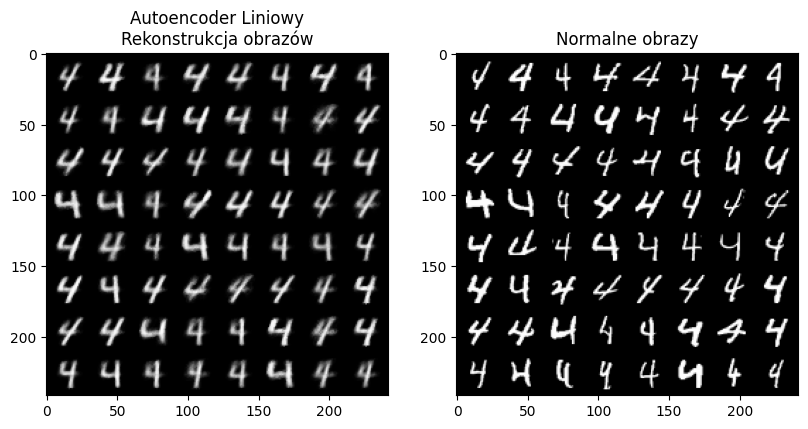

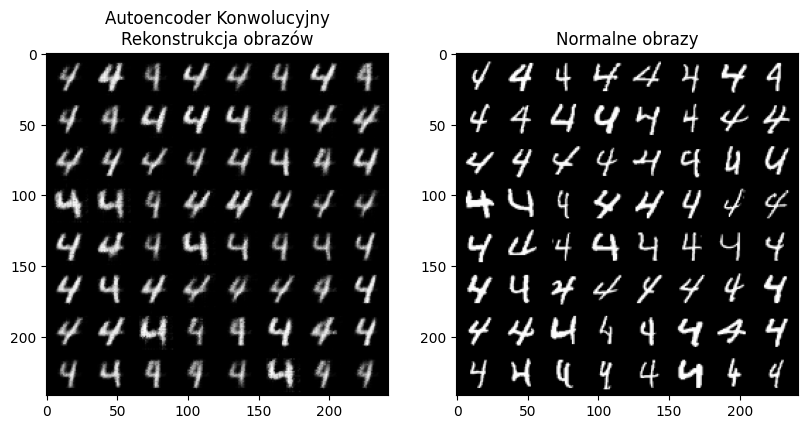

In [ ]:
dataiter = iter(trainloader_ae)
images, labels = next(dataiter)
model_names = ["Autoencoder Liniowy", "Autoencoder Konwolucyjny"]

for i,model in enumerate(models[1:]):
  with torch.no_grad():
      forward = model(images)
      loss = E(forward, images)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plt.title(f"{model_names[i]}\nRekonstrukcja obrazów")
  imshow(torchvision.utils.make_grid(forward))
  plt.subplot(1, 3, 2)
  plt.title(f"Normalne obrazy")
  imshow(torchvision.utils.make_grid(images))
  plt.show()

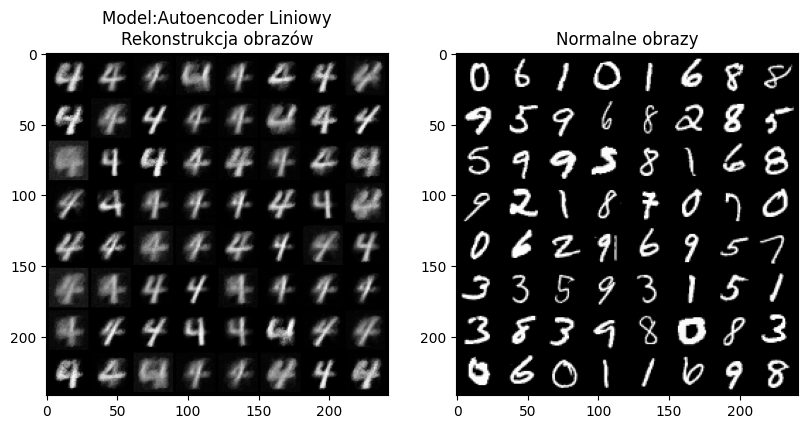

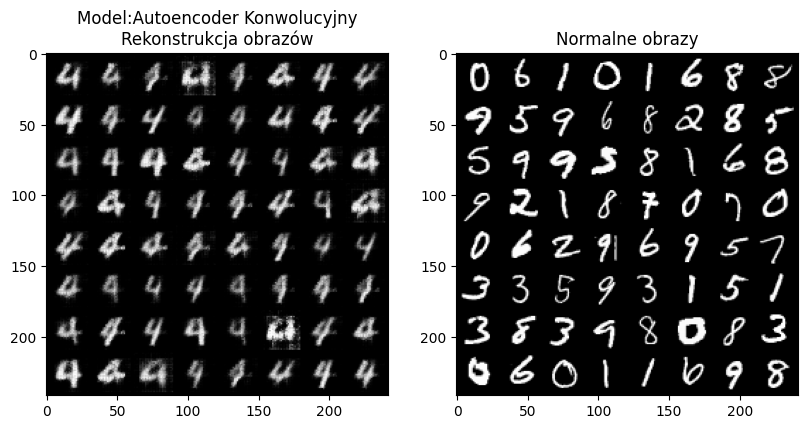

In [ ]:
dataiter = iter(testloader_ae)
images, labels = next(dataiter)
model_names = ["Autoencoder Liniowy", "Autoencoder Konwolucyjny"]

Status = None
for i,model in enumerate(models[1:]):
  with torch.no_grad():
      forward = model(images)
      loss = E(forward, images)
      if loss > T:
        Status = "Anomaly"
      else:
        Status = "Normal"

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  # plt.title(f"Model:{model.__class__.__name__}\n Status:{Status}\n Loss:{loss:2f}")
  plt.title(f"Model:{model_names[i]}\nRekonstrukcja obrazów")
  imshow(torchvision.utils.make_grid(forward))
  plt.subplot(1, 3, 2)
  plt.title(f"Normalne obrazy")
  imshow(torchvision.utils.make_grid(images))
  plt.show()

In [ ]:
testloader_single = torch.utils.data.DataLoader(Anomaly, batch_size=1, shuffle=False)
list_loss_array_anomaly = []
for model in models[1:]:
  with torch.no_grad():
    loss_array_anomaly = []
    for i ,data in enumerate(testloader_single):
        images, _ = data
        forward = model(images)
        loss = E(forward, images)
        loss_array_anomaly.append(loss.item())
  list_loss_array_anomaly.append(loss_array_anomaly)

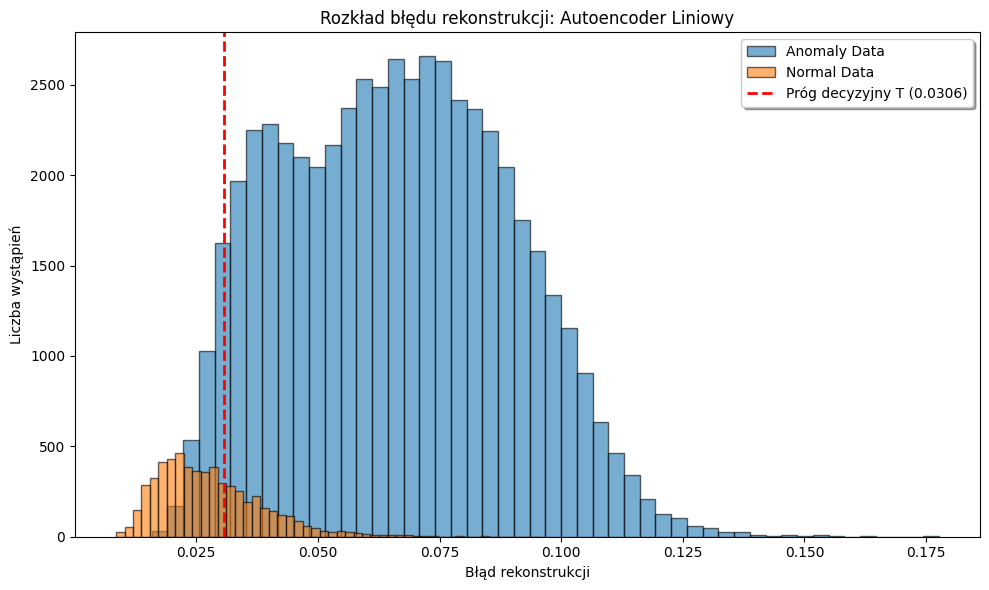

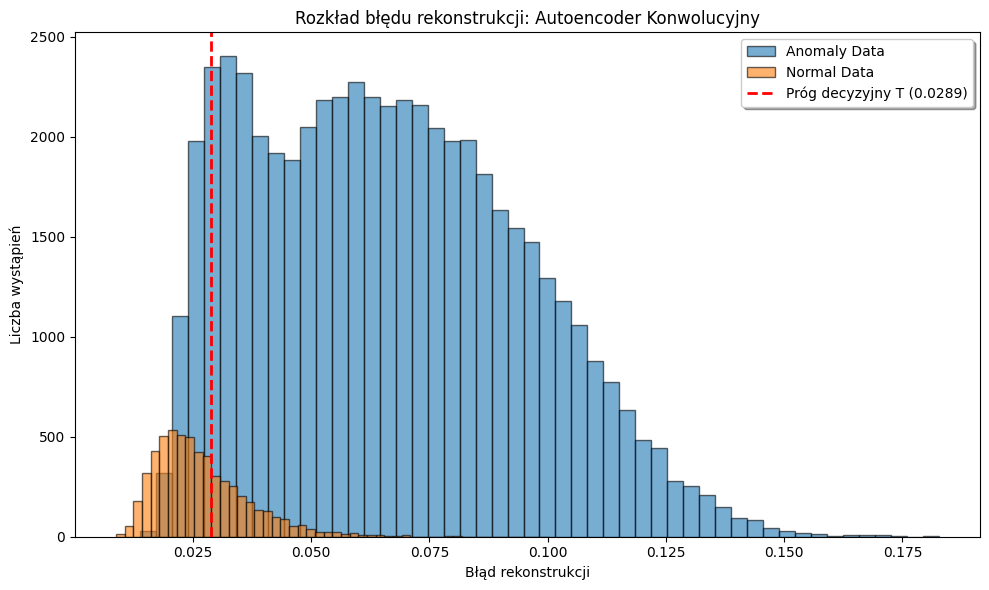

In [ ]:
model_names = ["Autoencoder Liniowy", "Autoencoder Konwolucyjny"]

for i, (loss_anomaly, loss_normal) in enumerate(zip(list_loss_array_anomaly, list_loss_array_normal)):
    plt.figure(figsize=(10, 6))

    plt.hist(loss_anomaly, bins=50, alpha=0.6, label='Anomaly Data', edgecolor='black')
    plt.hist(loss_normal, bins=50, alpha=0.6, label='Normal Data', edgecolor='black')

    current_T = list_T[i]
    plt.axvline(x=current_T, linestyle='--',color= "red", linewidth=2, label=f'Próg decyzyjny T ({current_T:.4f})')

    plt.title(f"Rozkład błędu rekonstrukcji: {model_names[i]}")
    plt.xlabel("Błąd rekonstrukcji")
    plt.ylabel("Liczba wystąpień")

    plt.legend(loc='upper right', frameon=True, shadow=True)

    plt.tight_layout()
    plt.show()

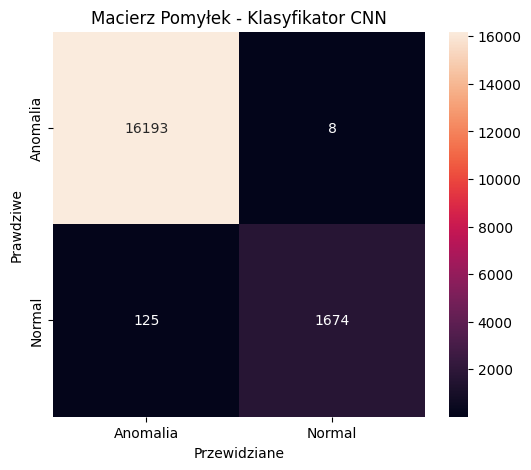

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in testloader_class:
        outputs = CNN_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_targets.extend(targets.numpy())

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Anomalia', 'Normal'], yticklabels=['Anomalia', 'Normal'])
plt.xlabel('Przewidziane')
plt.ylabel('Prawdziwe')
plt.title('Macierz Pomyłek - Klasyfikator CNN')
plt.show()

In [ ]:
ae_accuracies = []
model_names_ae = ["AE Liniowy", "AE Konwolucyjny"]

for i in range(len(list_loss_array_normal)):

    correct_normal = np.sum(np.array(list_loss_array_normal[i]) <= list_T[i])
    correct_anomaly = np.sum(np.array(list_loss_array_anomaly[i]) > list_T[i])

    total = len(list_loss_array_normal[i]) + len(list_loss_array_anomaly[i])
    accuracy = (correct_normal + correct_anomaly) / total * 100
    ae_accuracies.append(accuracy)

CNN_model.eval()
correct_cnn = 0
total_cnn = 0

with torch.no_grad():
    for images, targets in testloader_class:
        outputs = CNN_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_cnn += targets.size(0)
        correct_cnn += (predicted == targets).sum().item()

cnn_accuracy = (correct_cnn / total_cnn) * 100

models_all = model_names_ae + ["CNN Classifier"]
accuracies_all = ae_accuracies + [cnn_accuracy]

plt.figure(figsize=(10, 6))
colors = ['skyblue', 'steelblue', 'darkblue']
bars = plt.bar(models_all, accuracies_all, color=colors, edgecolor='black', width=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%',
             ha='center')

plt.ylim(0, 110)
plt.title("Porównanie dokładności wszystkich modeli")
plt.ylabel("Dokładność [%]")

plt.tight_layout()
plt.show()